In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def brier_score(pred_prob, ytrue):
  return np.mean((pred_prob - ytrue)**2)


def brier_score_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

In [3]:
# Read in data and clean it up for testing (i.e. use season averages)
DATA_PATH = 'drive/MyDrive/march_madness_2023/march-machine-learning-mania-2023__3-13-23/'

df = pd.read_csv(DATA_PATH + 'Mfinal_data_2003-2022.csv')
to_drop = [col for col in df.columns if '14' in col]
df.drop(to_drop, axis=1, inplace=True)

print(df.shape)
df.head()

(2496, 19)


,Season,TeamIDA,TeamIDB,SeedA,SeedB,OffEffA,DefEffA,EFTA,WinRatioA,GapAvgA,AvgRankA,OffEffB,DefEffB,EFTB,WinRatioB,GapAvgB,AvgRankB,ScoreDiff,WinA
0,2003,1421,1411,16,16,105.315164,115.456256,0.489800,0.448276,-7.241379,259.2,107.187241,105.071425,0.503036,0.600000,1.966667,259.4,8,1
1,2003,1112,1436,1,16,115.232944,95.117513,0.517632,0.892857,14.964286,2.6,106.911164,99.247639,0.494732,0.655172,4.655172,159.6,29,1
2,2003,1113,1272,10,7,113.782349,103.406731,0.517334,0.620690,6.793103,33.6,109.889666,97.004974,0.498337,0.793103,8.689655,21.8,13,1
3,2003,1141,1166,11,6,114.122499,105.421379,0.572835,0.793103,6.103448,43.4,118.566346,96.739284,0.567455,0.878788,14.909091,23.0,6,1
4,2003,1143,1301,8,9,109.611481,102.725168,0.524098,0.724138,4.724138,36.2,111.669631,105.001178,0.534189,0.600000,4.400000,45.0,2,1


In [4]:
# Set up X and Y
to_drop = ['Season', 'TeamIDA', 'TeamIDB', 'ScoreDiff', 'WinA']
X = df.drop(to_drop, axis=1)
Y = df['WinA']

X.head()

,SeedA,SeedB,OffEffA,DefEffA,EFTA,WinRatioA,GapAvgA,AvgRankA,OffEffB,DefEffB,EFTB,WinRatioB,GapAvgB,AvgRankB
0,16,16,105.315164,115.456256,0.489800,0.448276,-7.241379,259.2,107.187241,105.071425,0.503036,0.600000,1.966667,259.4
1,1,16,115.232944,95.117513,0.517632,0.892857,14.964286,2.6,106.911164,99.247639,0.494732,0.655172,4.655172,159.6
2,10,7,113.782349,103.406731,0.517334,0.620690,6.793103,33.6,109.889666,97.004974,0.498337,0.793103,8.689655,21.8
3,11,6,114.122499,105.421379,0.572835,0.793103,6.103448,43.4,118.566346,96.739284,0.567455,0.878788,14.909091,23.0
4,8,9,109.611481,102.725168,0.524098,0.724138,4.724138,36.2,111.669631,105.001178,0.534189,0.600000,4.400000,45.0


In [5]:
# Split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Use standard scaler on features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)

(1747, 14)


In [6]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Model, Input
from tensorflow.keras import metrics, regularizers, callbacks

!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-i8krrkua
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-i8krrkua
  Resolved https://github.com/tensorflow/docs to commit 39ff245f63086d506b803177806d60c293488819
  Preparing metadata (setup.py) ... done


In [7]:
histories = {}

plotter = tfdocs.plots.HistoryPlotter(metric='loss', smoothing_std=10)

In [8]:
# Original
inputs = Input(shape=(14,))
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs, name='original')
model.summary()

Model: "original"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1920      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                          

In [9]:
model.compile(optimizer='adam', 
              loss=brier_score_loss, 
              metrics=[metrics.BinaryCrossentropy()
              ])
history = model.fit(X_train_scaled, Y_train, 
                    batch_size=32, epochs=300, 
                    validation_data=(X_test_scaled, Y_test),
                    callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=50),
                    verbose=1)

Epoch 1/300
55/55 [==============================] - 2s 7ms/step - loss: 1.5716 - binary_crossentropy: 4.9989 - val_loss: 0.3614 - val_binary_crossentropy: 1.7091
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 0.8381 - binary_crossentropy: 3.7999 - val_loss: 0.2958 - val_binary_crossentropy: 1.2648
Epoch 3/300
55/55 [==============================] - 0s 4ms/step - loss: 0.6126 - binary_crossentropy: 3.1089 - val_loss: 0.2457 - val_binary_crossentropy: 0.8217
Epoch 4/300
55/55 [==============================] - 0s 4ms/step - loss: 0.4932 - binary_crossentropy: 2.6411 - val_loss: 0.2269 - val_binary_crossentropy: 0.7258
Epoch 5/300
55/55 [==============================] - 0s 3ms/step - loss: 0.4780 - binary_crossentropy: 2.4061 - val_loss: 0.2090 - val_binary_crossentropy: 0.6256
Epoch 6/300
55/55 [==============================] - 0s 3ms/step - loss: 0.4291 - binary_crossentropy: 2.1847 - val_loss: 0.2030 - val_binary_crossentropy: 0.5850
Epoch 7/300
55/55 [===

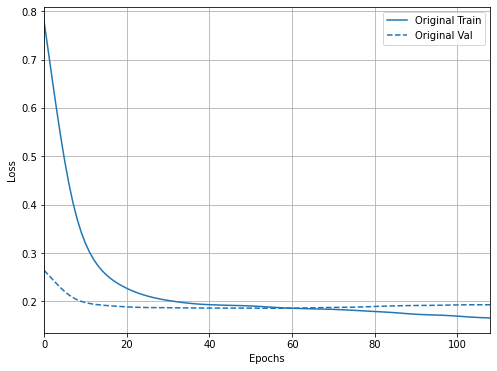

In [10]:
histories['original'] = history

plt.figure(figsize=(8,6))
plotter.plot(histories)

In [11]:
# Simple, small
inputs = Input(shape=(14,))
x = Dense(32, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs, name='simple_small')
model.summary()

Model: "simple_small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                480       
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_6 (Batc  (None, 32)               128       
 hNormalization)                                      

In [12]:
model.compile(optimizer='adam', 
              loss=brier_score_loss, 
              metrics=[metrics.BinaryCrossentropy()
              ])
history = model.fit(X_train_scaled, Y_train, 
                    batch_size=32, epochs=300, 
                    validation_data=(X_test_scaled, Y_test),
                    callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=50),
                    verbose=1)

Epoch 1/300
55/55 [==============================] - 2s 6ms/step - loss: 1.8475 - binary_crossentropy: 5.3691 - val_loss: 0.2670 - val_binary_crossentropy: 0.7812
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 0.9123 - binary_crossentropy: 4.0790 - val_loss: 0.2457 - val_binary_crossentropy: 0.7390
Epoch 3/300
55/55 [==============================] - 0s 4ms/step - loss: 0.6308 - binary_crossentropy: 3.3313 - val_loss: 0.2374 - val_binary_crossentropy: 0.7356
Epoch 4/300
55/55 [==============================] - 0s 3ms/step - loss: 0.5844 - binary_crossentropy: 3.0024 - val_loss: 0.2390 - val_binary_crossentropy: 0.7405
Epoch 5/300
55/55 [==============================] - 0s 4ms/step - loss: 0.5092 - binary_crossentropy: 2.8188 - val_loss: 0.2288 - val_binary_crossentropy: 0.7475
Epoch 6/300
55/55 [==============================] - 0s 4ms/step - loss: 0.4214 - binary_crossentropy: 2.1787 - val_loss: 0.2310 - val_binary_crossentropy: 0.7392
Epoch 7/300
55/55 [===

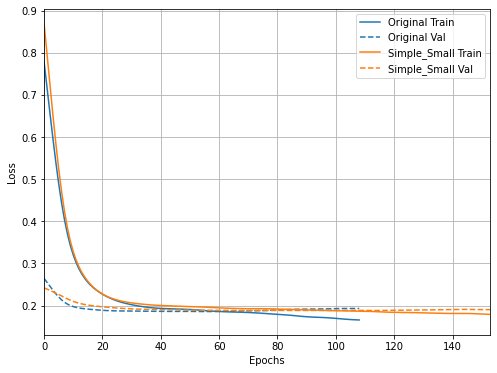

In [13]:
histories['simple_small'] = history

plt.figure(figsize=(8,6))
plotter.plot(histories)

In [14]:
# Simple, large
inputs = Input(shape=(14,))
x = Dense(512, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs, name='simple_large')
model.summary()

Model: "simple_large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_10 (Dense)            (None, 512)               7680      
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [15]:
model.compile(optimizer='adam', 
              loss=brier_score_loss, 
              metrics=[metrics.BinaryCrossentropy()
              ])
history = model.fit(X_train_scaled, Y_train, 
                    batch_size=32, epochs=300, 
                    validation_data=(X_test_scaled, Y_test),
                    callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=50),
                    verbose=1)

Epoch 1/300
55/55 [==============================] - 2s 13ms/step - loss: 1.9372 - binary_crossentropy: 4.8485 - val_loss: 0.2542 - val_binary_crossentropy: 0.8032
Epoch 2/300
55/55 [==============================] - 1s 13ms/step - loss: 0.8918 - binary_crossentropy: 3.8305 - val_loss: 0.2326 - val_binary_crossentropy: 0.7722
Epoch 3/300
55/55 [==============================] - 1s 10ms/step - loss: 0.6713 - binary_crossentropy: 3.3174 - val_loss: 0.2283 - val_binary_crossentropy: 0.7202
Epoch 4/300
55/55 [==============================] - 1s 13ms/step - loss: 0.5646 - binary_crossentropy: 2.7382 - val_loss: 0.2187 - val_binary_crossentropy: 0.7781
Epoch 5/300
55/55 [==============================] - 1s 13ms/step - loss: 0.4695 - binary_crossentropy: 2.3692 - val_loss: 0.2150 - val_binary_crossentropy: 0.8045
Epoch 6/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4059 - binary_crossentropy: 1.9663 - val_loss: 0.2107 - val_binary_crossentropy: 0.6226
Epoch 7/300
55/5

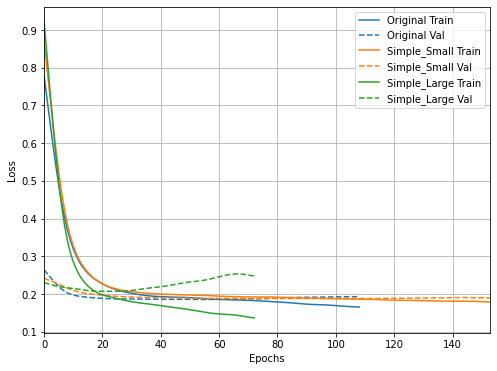

In [16]:
histories['simple_large'] = history

plt.figure(figsize=(8,6))
plotter.plot(histories)

In [17]:
# Shrinking layers, small
inputs = Input(shape=(14,))
x = Dense(64, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs, name='shrink_small')
model.summary()

Model: "shrink_small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_14 (Dense)            (None, 64)                960       
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_12 (Bat  (None, 32)               128       
 chNormalization)                                     

In [18]:
model.compile(optimizer='adam', 
              loss=brier_score_loss, 
              metrics=[metrics.BinaryCrossentropy()
              ])
history = model.fit(X_train_scaled, Y_train, 
                    batch_size=32, epochs=300, 
                    validation_data=(X_test_scaled, Y_test),
                    callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=50),
                    verbose=1)

Epoch 1/300
55/55 [==============================] - 2s 6ms/step - loss: 2.9037 - binary_crossentropy: 5.5438 - val_loss: 0.4807 - val_binary_crossentropy: 4.0295
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 1.4555 - binary_crossentropy: 4.7022 - val_loss: 0.4940 - val_binary_crossentropy: 4.1016
Epoch 3/300
55/55 [==============================] - 0s 4ms/step - loss: 1.0538 - binary_crossentropy: 4.4100 - val_loss: 0.4152 - val_binary_crossentropy: 2.9963
Epoch 4/300
55/55 [==============================] - 0s 3ms/step - loss: 0.8515 - binary_crossentropy: 4.0175 - val_loss: 0.3485 - val_binary_crossentropy: 2.1790
Epoch 5/300
55/55 [==============================] - 0s 4ms/step - loss: 0.6758 - binary_crossentropy: 3.3797 - val_loss: 0.2980 - val_binary_crossentropy: 1.4508
Epoch 6/300
55/55 [==============================] - 0s 3ms/step - loss: 0.5868 - binary_crossentropy: 3.1626 - val_loss: 0.2800 - val_binary_crossentropy: 1.3063
Epoch 7/300
55/55 [===

(0.0, 0.25)

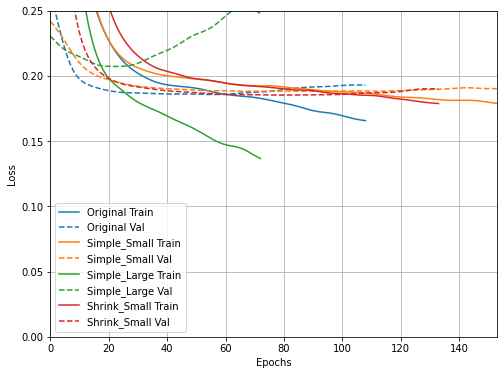

In [19]:
histories['shrink_small'] = history

plt.figure(figsize=(8,6))
plotter.plot(histories)
plt.ylim(0,0.25)

In [20]:
# Simple, small, regularized
inputs = Input(shape=(14,))
x = Dense(32, activation='relu',
          kernel_regularizer=regularizers.l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu',
          kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu',
          kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs, name='simple_small_reg')
model.summary()

Model: "simple_small_reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_18 (Dense)            (None, 32)                480       
                                                                 
 batch_normalization_14 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_15 (Bat  (None, 32)               128       
 chNormalization)                                 

In [25]:
model.compile(optimizer='adam', 
              loss=brier_score_loss, 
              metrics=[metrics.BinaryCrossentropy()
              ])
history = model.fit(X_train_scaled, Y_train, 
                    batch_size=32, epochs=300, 
                    validation_data=(X_test_scaled, Y_test),
                    callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=50),
                    verbose=1)

Epoch 1/300
55/55 [==============================] - 2s 7ms/step - loss: 0.1999 - binary_crossentropy: 0.6001 - val_loss: 0.1873 - val_binary_crossentropy: 0.5499
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 0.2023 - binary_crossentropy: 0.6112 - val_loss: 0.1888 - val_binary_crossentropy: 0.5548
Epoch 3/300
55/55 [==============================] - 0s 3ms/step - loss: 0.2030 - binary_crossentropy: 0.6336 - val_loss: 0.1893 - val_binary_crossentropy: 0.5555
Epoch 4/300
55/55 [==============================] - 0s 3ms/step - loss: 0.1983 - binary_crossentropy: 0.5924 - val_loss: 0.1874 - val_binary_crossentropy: 0.5487
Epoch 5/300
55/55 [==============================] - 0s 4ms/step - loss: 0.1983 - binary_crossentropy: 0.6019 - val_loss: 0.1875 - val_binary_crossentropy: 0.5489
Epoch 6/300
55/55 [==============================] - 0s 4ms/step - loss: 0.2024 - binary_crossentropy: 0.6158 - val_loss: 0.1888 - val_binary_crossentropy: 0.5543
Epoch 7/300
55/55 [===

(0.0, 0.25)

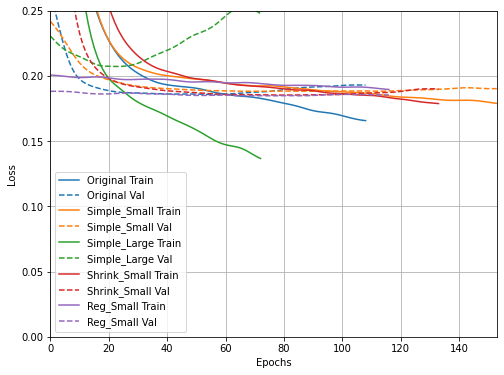

In [26]:
histories['reg_small'] = history

plt.figure(figsize=(8,6))
plotter.plot(histories)
plt.ylim(0,0.25)

In [27]:
# Simple, small, increased dropout
inputs = Input(shape=(14,))
x = Dense(32, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs, name='simple_small_drop')
model.summary()

Model: "simple_small_drop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_26 (Dense)            (None, 32)                480       
                                                                 
 batch_normalization_20 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_21 (Bat  (None, 32)               128       
 chNormalization)                                

In [28]:
model.compile(optimizer='adam', 
              loss=brier_score_loss, 
              metrics=[metrics.BinaryCrossentropy()
              ])
history = model.fit(X_train_scaled, Y_train, 
                    batch_size=32, epochs=300, 
                    validation_data=(X_test_scaled, Y_test),
                    callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=50),
                    verbose=1)

Epoch 1/300
55/55 [==============================] - 2s 9ms/step - loss: 4.1876 - binary_crossentropy: 6.2833 - val_loss: 0.3402 - val_binary_crossentropy: 1.1463
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 2.5204 - binary_crossentropy: 5.8496 - val_loss: 0.3195 - val_binary_crossentropy: 1.1264
Epoch 3/300
55/55 [==============================] - 0s 3ms/step - loss: 1.9525 - binary_crossentropy: 5.3808 - val_loss: 0.3014 - val_binary_crossentropy: 1.2139
Epoch 4/300
55/55 [==============================] - 0s 4ms/step - loss: 1.4674 - binary_crossentropy: 4.7575 - val_loss: 0.2953 - val_binary_crossentropy: 1.1265
Epoch 5/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1375 - binary_crossentropy: 4.5449 - val_loss: 0.2785 - val_binary_crossentropy: 1.0454
Epoch 6/300
55/55 [==============================] - 0s 4ms/step - loss: 0.9450 - binary_crossentropy: 4.1824 - val_loss: 0.2640 - val_binary_crossentropy: 0.9496
Epoch 7/300
55/55 [===

(0.0, 0.25)

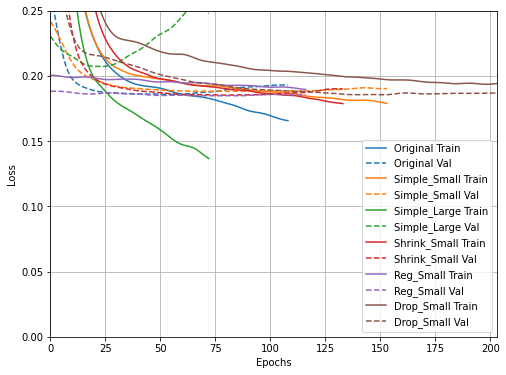

In [29]:
histories['drop_small'] = history

plt.figure(figsize=(8,6))
plotter.plot(histories)
plt.ylim(0,0.25)

In [30]:
# Tiny
inputs = Input(shape=(14,))
x = Dense(32, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs, name='tiny')
model.summary()

Model: "tiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_30 (Dense)            (None, 32)                480       
                                                                 
 batch_normalization_23 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 641
Trainable params: 577
Non-trainable params: 64
_______________________________________________________________

In [31]:
model.compile(optimizer='adam', 
              loss=brier_score_loss, 
              metrics=[metrics.BinaryCrossentropy()
              ])
history = model.fit(X_train_scaled, Y_train, 
                    batch_size=32, epochs=100, 
                    validation_data=(X_test_scaled, Y_test),
                    callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=25),
                    verbose=1)

Epoch 1/100
55/55 [==============================] - 1s 5ms/step - loss: 1.8865 - binary_crossentropy: 5.4563 - val_loss: 0.3772 - val_binary_crossentropy: 1.8360
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 0.8569 - binary_crossentropy: 3.9444 - val_loss: 0.3004 - val_binary_crossentropy: 1.1727
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 0.6776 - binary_crossentropy: 3.4825 - val_loss: 0.2735 - val_binary_crossentropy: 0.9916
Epoch 4/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5182 - binary_crossentropy: 2.5983 - val_loss: 0.2560 - val_binary_crossentropy: 0.9040
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 0.4788 - binary_crossentropy: 2.4205 - val_loss: 0.2420 - val_binary_crossentropy: 0.8741
Epoch 6/100
55/55 [==============================] - 0s 3ms/step - loss: 0.4209 - binary_crossentropy: 2.0982 - val_loss: 0.2281 - val_binary_crossentropy: 0.7857
Epoch 7/100
55/55 [===

(0.0, 0.25)

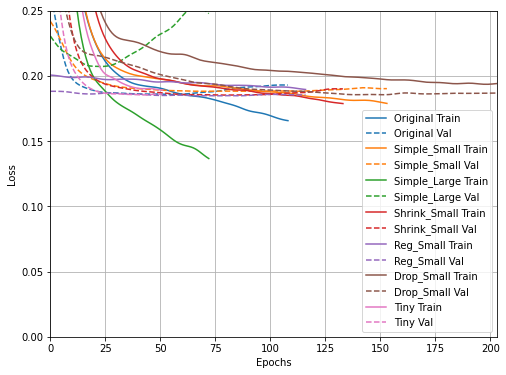

In [32]:
histories['tiny'] = history

plt.figure(figsize=(8,6))
plotter.plot(histories)
plt.ylim(0,0.25)